# In this notebook a simple Q learner will be trained and evaluated. The Q learner recommends when to buy or sell shares of one particular stock, and in which quantity (in fact it determines the desired fraction of shares in the total portfolio value). One initial attempt was made to train the Q-learner with multiple processes, but it was unsuccessful.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
NUM_THREADS = 1
LOOKBACK = -1  # 252*4 + 28
STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]

# Get the data
SYMBOL = 'SPY'
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
data_train_df = total_data_train_df[SYMBOL].unstack()
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')
data_test_df = total_data_test_df[SYMBOL].unstack()
if LOOKBACK == -1:
    total_data_in_df = total_data_train_df
    data_in_df = data_train_df
else:
    data_in_df = data_train_df.iloc[-LOOKBACK:]
    total_data_in_df = total_data_train_df.loc[data_in_df.index[0]:]

# Create many agents
index = np.arange(NUM_THREADS).tolist()
env, num_states, num_actions = sim.initialize_env(total_data_train_df, 
                                                  SYMBOL, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
agents = [Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.9999,
                dyna_iterations=20,
                name='Agent_{}'.format(i)) for i in index]

In [3]:
def show_results(results_list, data_in_df, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = SYMBOL
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's show the symbols data, to see how good the recommender has to be.

In [4]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_in_df['Close'].iloc[STARTING_DAYS_AHEAD:]))))

Sharpe ratio: 0.4566770027925799
Cum. Ret.: 3.304502617801047
AVG_DRET: 0.0003519913231219332
STD_DRET: 0.012235538451970583
Final value: 205.54


In [5]:
# Simulate (with new envs, each time)
n_epochs = 7

for i in range(n_epochs):
    tic = time()
    env.reset(STARTING_DAYS_AHEAD)
    results_list = sim.simulate_period(total_data_in_df, 
                                       SYMBOL,
                                       agents[0],
                                       starting_days_ahead=STARTING_DAYS_AHEAD,
                                       possible_fractions=POSSIBLE_FRACTIONS,
                                       verbose=False,
                                       other_env=env)
    toc = time()
    print('Epoch: {}'.format(i))
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
    show_results([results_list], data_in_df)

Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.6128144264221191s.  Value: 13237.46000000003...Epoch: 0
Elapsed time: 259.5322186946869 seconds.
Random Actions Rate: 0.5787243211477068
Sharpe ratio: 0.167849497015874
Cum. Ret.: 0.3256360000000029
AVG_DRET: 8.954840953528278e-05
STD_DRET: 0.008469116421933043
Final value: 13256.36000000003
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.7248144149780273s.  Value: 52809.56000000003...Epoch: 1
Elapsed time: 256.4391598701477 seconds.
Random Actions Rate: 0.3417569794774213
Sharpe ratio: 0.6965491843077297
Cum. Ret.: 4.2319340000000025
AVG_DRET: 0.000345054298491507
STD_DRET: 0.00786386273810396
Final value: 52319.340000000026
-----------------------

Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.3833761215209961s.  Value: 956187.2199999993...Sharpe ratio: 2.2964510954840325
Cum. Ret.: 94.75696199999993
AVG_DRET: 0.0008848935043389804
STD_DRET: 0.006116937967095524
Final value: 957569.6199999993
----------------------------------------------------------------------------------------------------


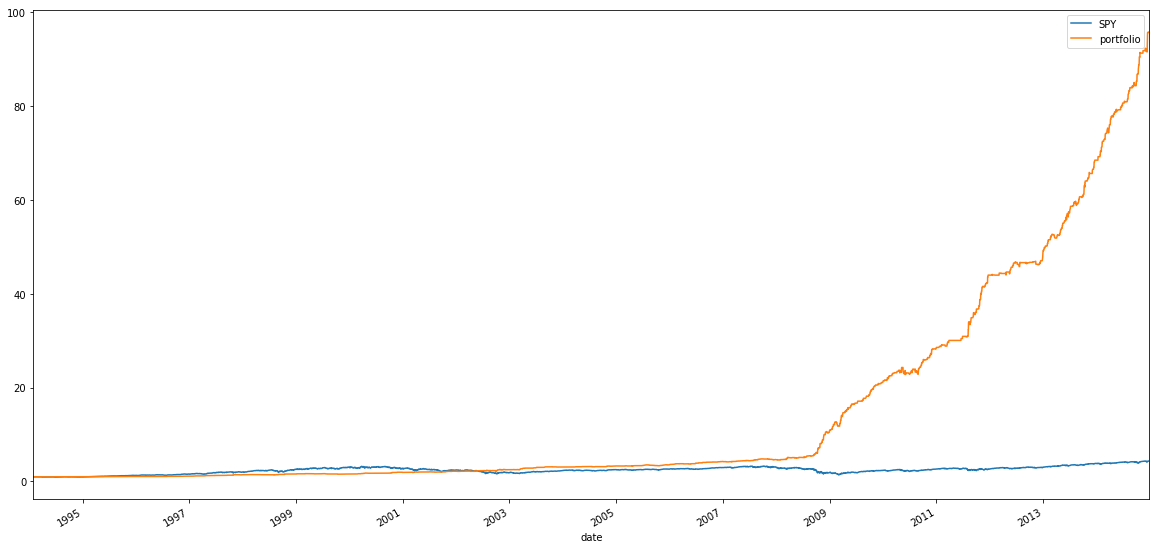

In [6]:
env.reset(STARTING_DAYS_AHEAD)
results_list = sim.simulate_period(total_data_in_df, 
                                   SYMBOL, agents[0], 
                                   learn=False, 
                                   starting_days_ahead=STARTING_DAYS_AHEAD,
                                   possible_fractions=POSSIBLE_FRACTIONS,
                                   other_env=env)
show_results([results_list], data_in_df, graph=True)

## Let's run the trained agent, with the test set

### First a non-learning test: this scenario would be worse than what is possible (in fact, the q-learner can learn from past samples in the test set without compromising the causality).

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.310805082321167s.  Value: 10655.170000000007.Epoch: 6
Elapsed time: 14.224964618682861 seconds.
Random Actions Rate: 0.024544019369877303
Sharpe ratio: 0.4267994866360769
Cum. Ret.: 0.0652820000000005
AVG_DRET: 0.00014598522542084606
STD_DRET: 0.005429818174302576
Final value: 10652.820000000005
----------------------------------------------------------------------------------------------------


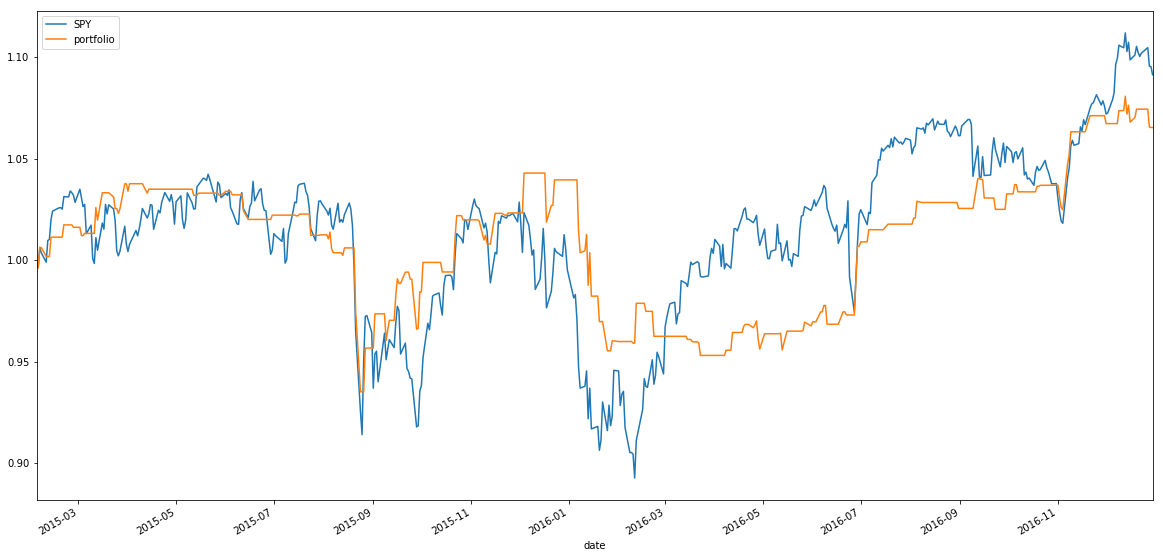

In [7]:
TEST_DAYS_AHEAD = 20

env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

### And now a "realistic" test, in which the learner continues to learn from past samples in the test set (it even makes some random moves, though very few).

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.3972902297973633s.  Value: 10686.960000000001.Epoch: 6
Elapsed time: 18.820592880249023 seconds.
Random Actions Rate: 0.02338666058186899
Sharpe ratio: 0.48863969848043476
Cum. Ret.: 0.06846099999999988
AVG_DRET: 0.00014911669513211861
STD_DRET: 0.00484437543090722
Final value: 10684.609999999999
----------------------------------------------------------------------------------------------------


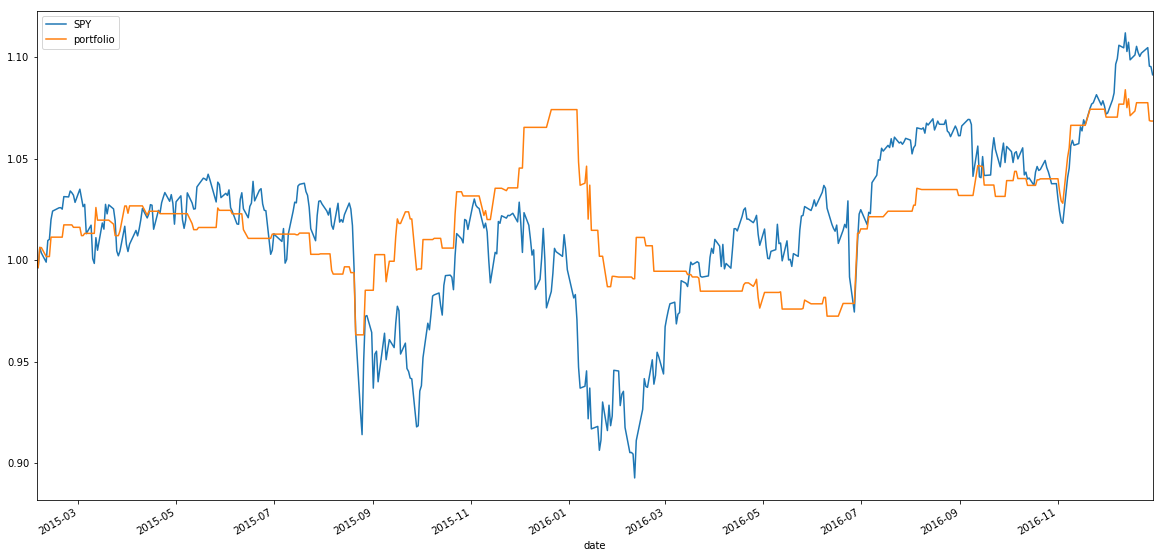

In [8]:
env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=True,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

## What are the metrics for "holding the position"?

In [9]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))))

Sharpe ratio: 0.44271542660031676
Cum. Ret.: 0.1070225832012679
AVG_DRET: 0.00025103195406808796
STD_DRET: 0.009001287260690292
Final value: 223.53


In [10]:
import pickle
with open('../../data/dyna_10000_states_full_training.pkl', 'wb') as best_agent:
    pickle.dump(agents[0], best_agent)